Parse the raw event log to compare CPU and GPU scan parquet operations.

In [56]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cpu_profiles = "/opt/data/profiles/dataproc-cpu-sf3k"
gpu_profiles = "/opt/data/profiles/dataproc-gpu-sf3k"
cpu_events = "/opt/data/events/dataproc-cpu-sf3k"
gpu_events = "/opt/data/events/dataproc-gpu-sf3k"

cpu_profile_dirs = os.listdir(cpu_profiles)
cpu_profile_dirs.sort()
gpu_profile_dirs = os.listdir(gpu_profiles)
gpu_profile_dirs.sort()

cpu_event_files = os.listdir(cpu_events)
cpu_event_files.sort()
gpu_event_files = os.listdir(gpu_events)
gpu_event_files.sort()

num_apps = len(cpu_event_files)
assert len(cpu_event_files) == num_apps
assert len(gpu_event_files) == num_apps
assert len(cpu_profile_dirs) == num_apps
assert len(gpu_profile_dirs) == num_apps
num_apps

103

In [57]:
class ScanParquet:
    def __init__(self, group=None):
        self.output_rows = 0
        self.files_read = 0
        self.size_files_read = 0
        self.partitions_read = 0
        self.scan_time = 0 
        if group is None:
            return
        for row in group.itertuples():
            if row.name == "number of output rows" or row.name == "output rows":
                self.output_rows = row.total
            elif row.name == "number of files read":
                self.files_read = row.total
            elif row.name == "size of files read":
                self.size_files_read = row.total
            elif row.name == "number of partitions read" or row.name == "partitions":
                self.partitions_read = row.total
            elif row.name == "scan time":
                self.scan_time = row.total
                self.accumulator_id = row.accumulatorId
        
    def __eq__(self, other):
        if isinstance(other, ScanParquet):
            return (self.output_rows == 0 or other.output_rows == 0 or self.output_rows == other.output_rows) and \
                   (self.files_read == 0 or other.files_read == 0 or self.files_read == other.files_read) and \
                   (self.size_files_read == 0 or other.size_files_read == 0 or self.size_files_read == other.size_files_read) and \
                   (self.partitions_read == 0 or other.partitions_read == 0 or self.partitions_read == other.partitions_read)
        return False
    
    def __str__(self):
        return f"{self.output_rows}, {self.files_read}, {self.size_files_read}, {self.partitions_read}, {self.scan_time}"
    
    
def collect(node, scan_list, scan_map):
    if node['nodeName'] == 'GpuScan parquet ' or node['nodeName'] == 'Scan parquet ':
        for m in node['metrics']:
            if m['name'] == 'scan time':
                accumulator_id = m['accumulatorId']
                scan_list.append(scan_map.get(accumulator_id, ScanParquet()))
    for child in node['children']:
        collect(child, scan_list, scan_map)


def collect_scans(profile_dir, event_file):
    sql_info = pd.read_csv(f"{profile_dir}/sql_plan_metrics_for_application.csv")
    filtered = sql_info[(sql_info["nodeName"].str.contains("Scan parquet "))]
    grouped = filtered.groupby("nodeID")
    scan_dict = {}
    for _, group in grouped:
        scan = ScanParquet(group)
        scan_dict[scan.accumulator_id] = scan

    scans = []
    with open(event_file, "r") as f:
        for line in f:
            event = json.loads(line)
            if "sparkPlanInfo" in event:
                scans.clear()
                collect(event["sparkPlanInfo"], scans, scan_dict)
    return sorted(scans, key=lambda s: (s.output_rows, s.files_read, s.size_files_read, s.partitions_read))


cpu_times = []
gpu_times = []
cpu_query_times = []
gpu_query_times = []
for i in range(num_apps):
    print(f"Processing cpu profile {cpu_profile_dirs[i]}, event file {cpu_event_files[i]}")
    cpu_scans = collect_scans(f"{cpu_profiles}/{cpu_profile_dirs[i]}", f"{cpu_events}/{cpu_event_files[i]}")
    print(f"Processing gpu profile {gpu_profile_dirs[i]}, event file {gpu_event_files[i]}")
    gpu_scans = collect_scans(f"{gpu_profiles}/{gpu_profile_dirs[i]}", f"{gpu_events}/{gpu_event_files[i]}")
    if cpu_scans != gpu_scans:
        print(f"Warning: cpu and gpu scan times are different: {cpu_scans} vs {gpu_scans}")
        continue
    print("; ".join(str(s) for s in cpu_scans))
    print("; ".join(str(s) for s in gpu_scans))
    cpu_times.extend(s.scan_time for s in cpu_scans)
    gpu_times.extend(s.scan_time for s in gpu_scans)
    cpu_query_times.append(sum(s.scan_time for s in cpu_scans))
    gpu_query_times.append(sum(s.scan_time for s in gpu_scans))

Processing cpu profile application_1702070228385_0253, event file eventlog-cpu-sf3k-query01
Processing gpu profile application_1702268529525_0508, event file eventlog-gpu-sf3k-query01
1350, 1, 118743, 0, 631; 73049, 1, 1843042, 0, 631; 73049, 1, 1843042, 0, 631; 73049, 1, 1843042, 0, 631; 73049, 1, 1843042, 0, 631; 30000000, 1, 1648909020, 0, 30065; 166763558, 365, 9008965341, 365, 125172; 166763558, 365, 9008965341, 365, 304101
1350, 1, 118743, 0, 449; 73049, 1, 1843042, 0, 449; 73049, 1, 1843042, 0, 449; 73049, 1, 1843042, 0, 449; 73049, 1, 1843042, 0, 482; 30000000, 1, 1648909020, 0, 29727; 166763558, 365, 9008965341, 365, 79344; 166763558, 365, 9008965341, 365, 200279
Processing cpu profile application_1702070228385_0254, event file eventlog-cpu-sf3k-query02
Processing gpu profile application_1702268529525_0509, event file eventlog-gpu-sf3k-query02
73049, 1, 1843042, 0, 611; 73049, 1, 1843042, 0, 653; 73049, 1, 1843042, 0, 611; 73049, 1, 1843042, 0, 666; 2159428588, 1823, 141027005

0.552193079053386 7341.835729355008


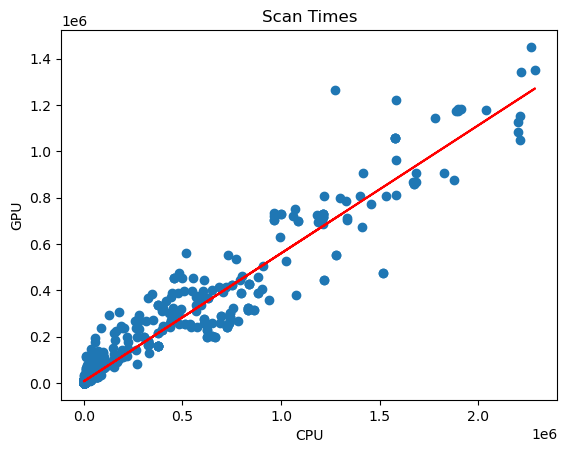

In [58]:
# Create a scatter plot
plt.scatter(cpu_times, gpu_times)

# Calculate the linear regression line
slope, intercept = np.polyfit(cpu_times, gpu_times, 1)
print(slope, intercept)
regression_line = np.array(cpu_times) * slope + intercept

# Plot the linear regression line
plt.plot(cpu_times, regression_line, color='red')  # you can choose any color you like for the line

# Adding title and labels (optional)
plt.title("Scan Times")
plt.xlabel("CPU")
plt.ylabel("GPU")

# Show the plot
plt.show()

102 102
0.5382760734674107 115776.39728574119


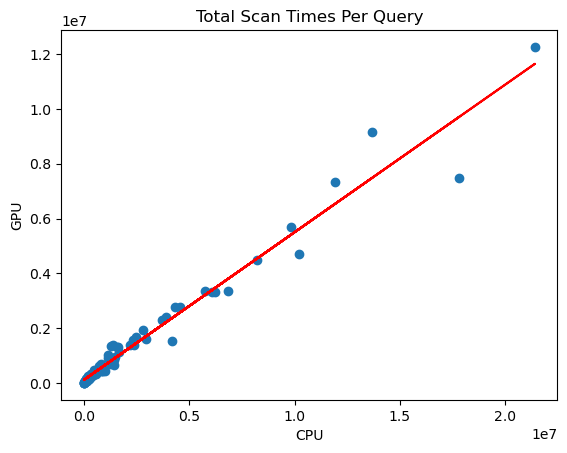

In [59]:
# Create a scatter plot
plt.scatter(cpu_query_times, gpu_query_times)
print(len(cpu_query_times), len(gpu_query_times))

# Calculate the linear regression line
slope, intercept = np.polyfit(cpu_query_times, gpu_query_times, 1)
print(slope, intercept)
regression_line = np.array(cpu_query_times) * slope + intercept

# Plot the linear regression line
plt.plot(cpu_query_times, regression_line, color='red')  # you can choose any color you like for the line

# Adding title and labels (optional)
plt.title("Total Scan Times Per Query")
plt.xlabel("CPU")
plt.ylabel("GPU")

# Show the plot
plt.show()